# |DPC| and parallax-corrected images in py4dstem



In [2]:
import numpy as np
import py4DSTEM
import h5py
import cupy as cp
print(py4DSTEM.__version__)
#import bitshuffle.h5


0.14.1


In [3]:
file_path = 'Z:/shared/ArinaData/2023Feb23_phages/'
filename = file_path+'2023Feb23_KE13_1_t2_s0_master.h5' 
scan_width, scan_height = 1024, 1024

In [4]:
filename

'Z:/shared/ArinaData/2023Feb23_phages/2023Feb23_KE13_1_t2_s0_master.h5'

### Load data, basic visualization

In [5]:
f = h5py.File(filename, "r")
nimages = 0

def processDataSet(dset, start_index, array, scan_width):
    image_index = start_index
    nimages_dset = dset.shape[0]

    for i in range(nimages_dset):
        #array[int(image_index%scan_width), int(image_index/scan_width)] = dset[i].astype(array.dtype)
        array[image_index] = dset[i].astype(array.dtype)
        
        # if image_index% 5000 == 0:
            # print(f"Images converted: {image_index}")
            # DM.ExecuteScriptString("DoEvents()")
        
        image_index = image_index + 1
        
    return image_index

#Count the number of images in all datasets
for dset in f["entry"]["data"]:
    nimages = nimages + f["entry"]["data"][dset].shape[0]
    height = f["entry"]["data"][dset].shape[1]
    width = f["entry"]["data"][dset].shape[2]
    dtype = f["entry"]["data"][dset].dtype

#guess_scan_width = int(math.sqrt(nimages))
#scan_width = askinteger('Enter Scan Width', 'Scan Width in Pixel', initialvalue=guess_scan_width)
#scan_height = int(nimages/scan_width)

if dtype.type is np.uint32:
    print(f"Dataset is uint32 but will be converted to uint16")
    dtype = np.dtype(np.uint16)

print(f"Dataset [{scan_width} {scan_height} {width} {height} @ {dtype}]")
#array = np.empty((scan_width, scan_height, width, height), dtype=dtype)
array = np.empty((nimages, width, height), dtype=dtype)

image_index = 0

for dset in f["entry"]["data"]:
    image_index = processDataSet(f["entry"]["data"][dset], image_index, array, scan_width)

if f.__bool__(): 
    f.close()

Dataset [1024 1024 96 96 @ uint16]


In [12]:
dataset = py4DSTEM.DataCube(
    np.flip(array.reshape(scan_width, scan_height,array.data.shape[1],array.data.shape[2]), axis = 0))

dataset.data.shape

(1024, 1024, 96, 96)

In [13]:
# Calculate the mean diffraction pattern
dataset.get_dp_mean();

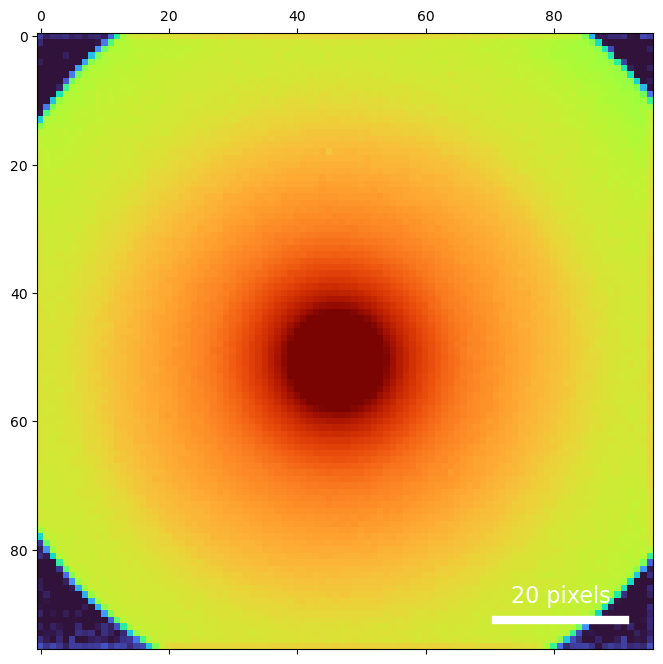

In [14]:
# plot the mean diffraction pattern
py4DSTEM.show(
    dataset.tree('dp_mean'),
    scaling = 'log',
    cmap = 'turbo',
)

In [15]:
#dataset_cropped = py4DSTEM.DataCube(data = dataset.data[256:-256,256:-256,16:-16,20:-12]) #33:-37,35:-35])
dataset_cropped = py4DSTEM.DataCube(data = dataset.data[:,:,:,:]) 

In [16]:
dataset_cropped.get_dp_mean()

VirtualDiffraction( A 2-dimensional array of shape (96, 96) called 'dp_mean',
                    with dimensions:

                    dim0 = [0,1,...] pixels
                    dim1 = [0,1,...] pixels
)

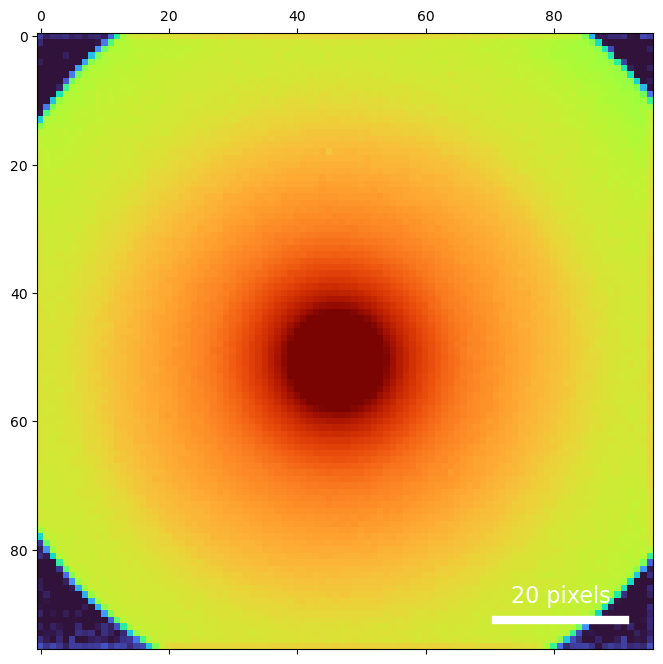

In [17]:
py4DSTEM.show(
    dataset_cropped.tree('dp_mean'),
    scaling = 'log',
    cmap = 'turbo',
)

### Virtual images

(50.51059745462345, 46.09717369388153)

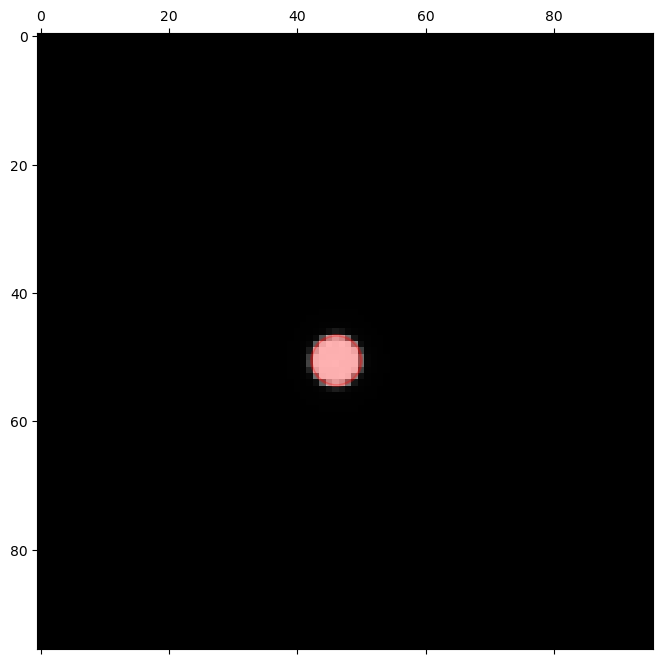

In [18]:
# Get probe radius in pixels
probe_radius_pixels, probe_qx0, probe_qy0 = dataset_cropped.get_probe_size(plot = True)
probe_radius_pixels
probe_qx0,probe_qy0

In [19]:
# Calibrate
dataset_cropped.calibration.set_Q_pixel_size(0.8/probe_radius_pixels) #     #np "730mm"   (0.1472) mrad
dataset_cropped.calibration.set_Q_pixel_units('mrad') #   ('mrad')
dataset_cropped.calibration.set_R_pixel_size(15.0)
dataset_cropped.calibration.set_R_pixel_units('A')

In [20]:
# Make a virtual bright field and dark field image
expand_BF = 2.0  # expand radius by 2 pixels to encompass the full center disk

center = (probe_qx0, probe_qy0)
radius_BF = probe_radius_pixels + expand_BF
radii_DF = (probe_radius_pixels + expand_BF, 100)

dataset_cropped.get_virtual_image(
    mode = 'circle',
    geometry = (center,radius_BF),
    name = 'bright_field',
)
dataset_cropped.get_virtual_image(
    mode = 'annulus',
    geometry = (center,radii_DF),
    name = 'dark_field',
);

100%|█████████████████████████████████████████████████████████████████████| 1048576/1048576 [00:35<00:00, 29203.54it/s]


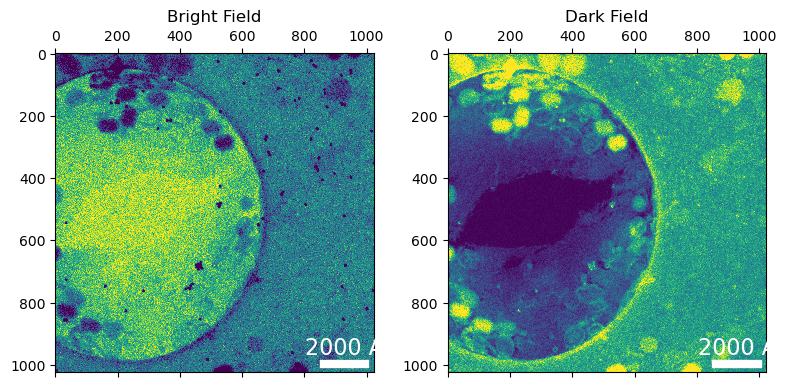

In [21]:
# plot the virtual images
py4DSTEM.show(
    [
        dataset_cropped.tree('bright_field'),
        dataset_cropped.tree('dark_field'),               
    ],
    cmap='viridis',
    # ticks = False,
    axsize=(4,4),
    title=['Bright Field','Dark Field'],
)

### Differential Phase Contrast (DPC)

D:\anaconda3\envs\py4dstem\lib\site-packages\py4DSTEM\process\phase\iterative_base_class.py:527: UserWarning: Best fit rotation forced to 180 degrees.
  warnings.warn(
D:\anaconda3\envs\py4dstem\lib\site-packages\py4DSTEM\process\phase\iterative_base_class.py:541: UserWarning: Transpose of intensities forced to False.
  warnings.warn(


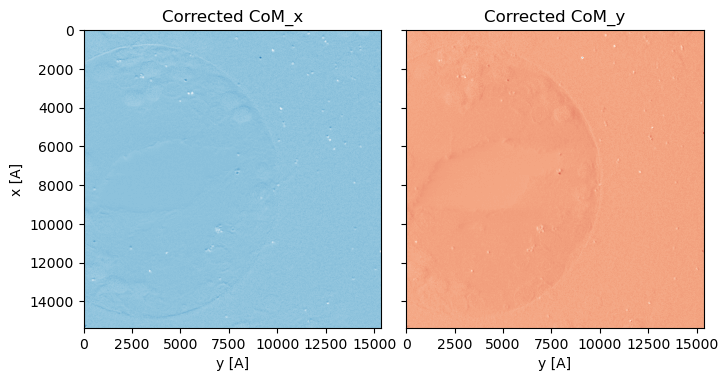

In [22]:
# Filtering can help us remove some of the low frequency artifacts

dpc_filtered = py4DSTEM.process.phase.DPCReconstruction(
   dataset_cropped, 
   energy = 200e3,
).preprocess(
    force_com_transpose=False, 
    force_com_rotation=180,
)

Reconstructing phase:  39%|██████████████████████▎                                  | 25/64 [00:42<01:05,  1.69s/ iter]
D:\anaconda3\envs\py4dstem\lib\site-packages\py4DSTEM\process\phase\iterative_dpc.py:726: UserWarning: Step-size has decreased below stopping criterion 1e-06.
  warnings.warn(


DPCReconstruction( A Node called 'dpc_reconstruction', containing the following top-level objects in its tree:

)

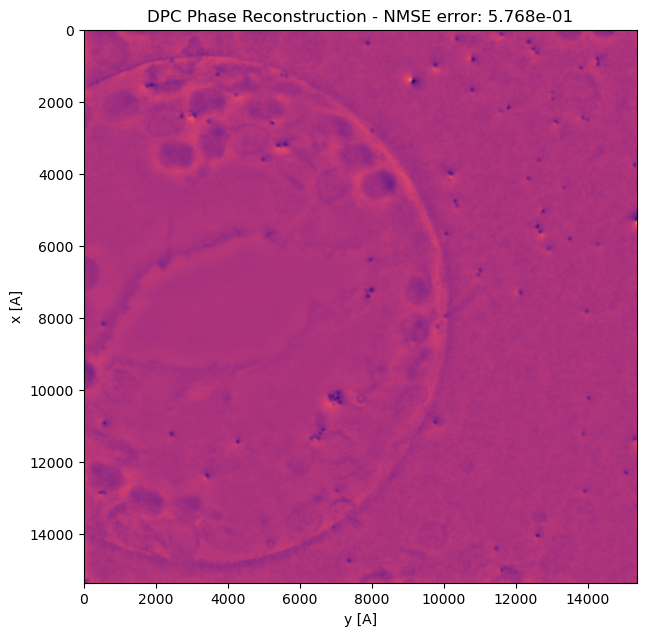

In [23]:
dpc_filtered.reconstruct(
    reset = True,
    q_highpass = 0.00035
).visualize()

### parallax

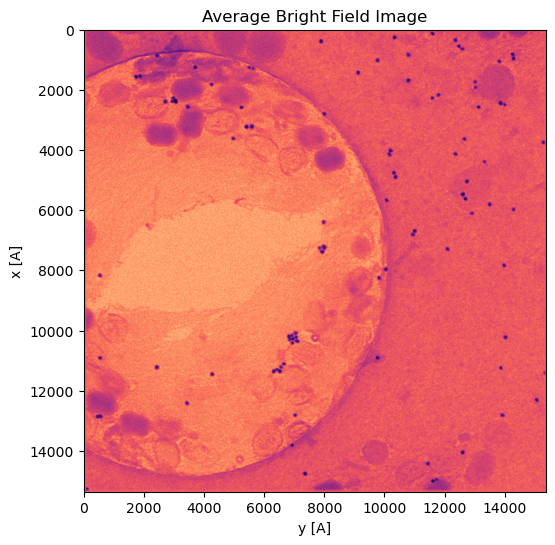

In [24]:
# initialize the reconstruction class
parallax = py4DSTEM.process.phase.ParallaxReconstruction(
    datacube = dataset_cropped,
    energy = 200e3,
    device = "cpu", 
    verbose = True,
    object_padding_px=(16,16),
).preprocess(
    normalize_images=True,
    plot_average_bf=True,
    edge_blend=8,
    defocus_guess = 0
)

Alignment at bin 2: 100%|██████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.19 image subsets/s]


ParallaxReconstruction( A Node called 'parallax_reconstruction', containing the following top-level objects in its tree:

)

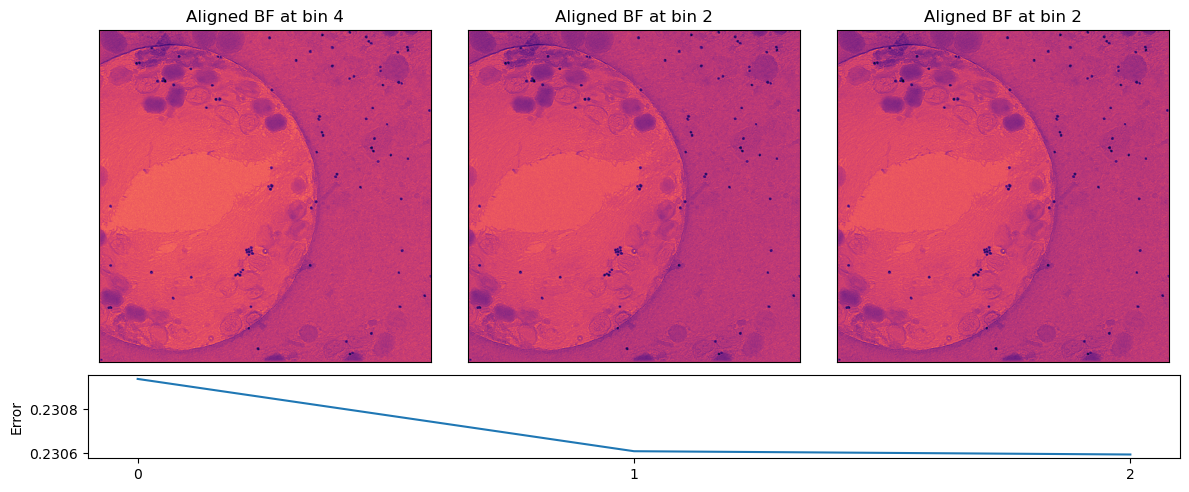

In [25]:
parallax.reconstruct(
    min_alignment_bin = 2,
)

In [26]:
parallax.aberration_fit()

Rotation of Q w.r.t. R = 3.016 deg
Astigmatism (A1x,A1y)  = (-5695,-1812) Ang
Aberration C1          = -45402 Ang
Defocus dF             =  45402 Ang


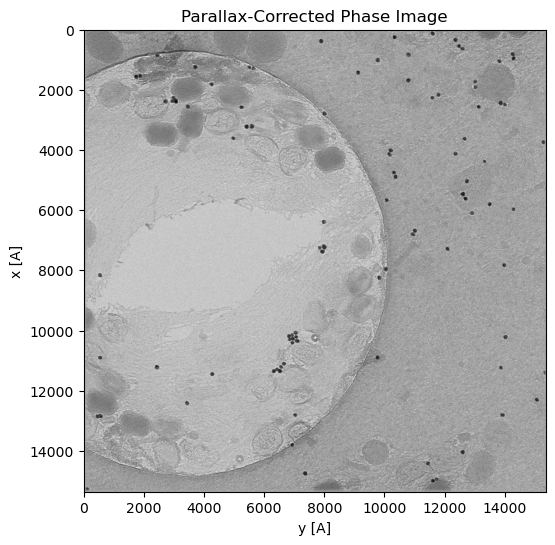

In [27]:
parallax.aberration_correct()